In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## RG climatology

In [41]:
ds_ct = xr.open_dataset('/swot/SUM05/amf2288/RG_clim/RG_ArgoClim_Temperature_2019.nc', decode_times=False)
ds_sa = xr.open_dataset('/swot/SUM05/amf2288/RG_clim/RG_ArgoClim_Salinity_2019.nc', decode_times=False)

In [42]:
# Define correct units and calendar
units = "months since 2004-01-01 00:00:00"
calendar = "360_day"  # Must be 360_day for months-based units

# Convert TIME to datetime
time_values = cftime.num2date(ds_ct.TIME.values, units=units, calendar=calendar)

# Convert to numpy datetime64 for easier handling
ds_ct["TIME"] = xr.DataArray(np.array(time_values, dtype="datetime64[ns]"), dims="TIME")
ds_sa["TIME"] = xr.DataArray(np.array(time_values, dtype="datetime64[ns]"), dims="TIME")

In [39]:
ds_ct

<xarray.Dataset> Size: 2GB
Dimensions:                   (LONGITUDE: 360, LATITUDE: 145, PRESSURE: 58,
                               TIME: 180)
Coordinates:
  * LONGITUDE                 (LONGITUDE) float32 1kB 20.5 21.5 ... 378.5 379.5
  * LATITUDE                  (LATITUDE) float32 580B -64.5 -63.5 ... 78.5 79.5
  * PRESSURE                  (PRESSURE) float32 232B 2.5 10.0 ... 1.975e+03
  * TIME                      (TIME) datetime64[ns] 1kB 2004-01-16 ... 2018-1...
Data variables:
    ARGO_TEMPERATURE_MEAN     (PRESSURE, LATITUDE, LONGITUDE) float32 12MB ...
    ARGO_TEMPERATURE_ANOMALY  (TIME, PRESSURE, LATITUDE, LONGITUDE) float32 2GB ...
    BATHYMETRY_MASK           (PRESSURE, LATITUDE, LONGITUDE) float32 12MB ...
    MAPPING_MASK              (PRESSURE, LATITUDE, LONGITUDE) float32 12MB ...

In [40]:
press = 1000
time = '2018-12'

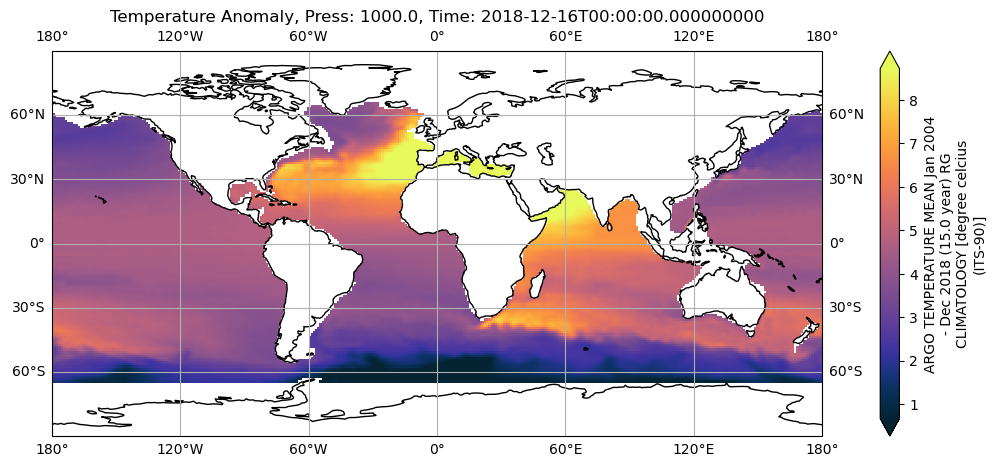

In [48]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
data = ds_ct.sel(PRESSURE=press, method='nearest').sel(TIME=time, method='nearest').ARGO_TEMPERATURE_MEAN
data.plot(x='LONGITUDE',y='LATITUDE',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.thermal, robust=True)
ax.set_title('Mean Temperature, Press: {}, Time: {}'.format(data.PRESSURE.values, data.TIME.values));

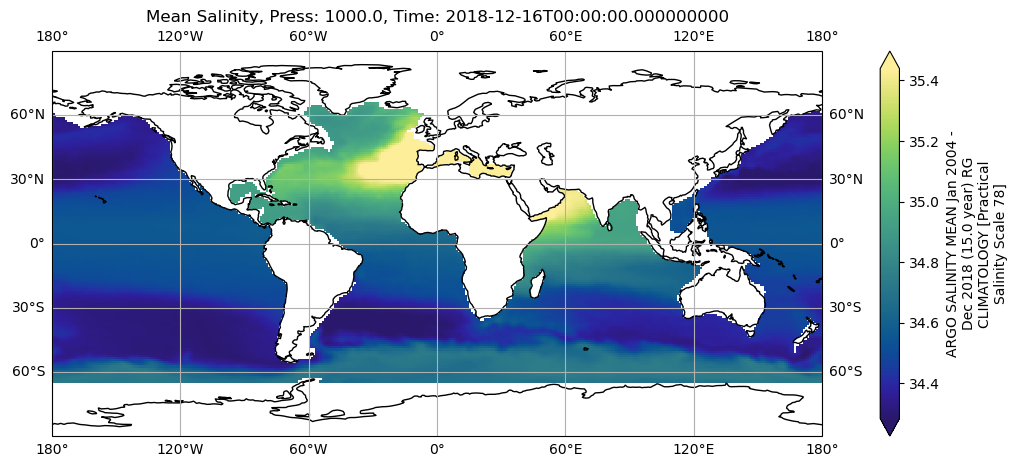

In [50]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
data = ds_sa.sel(PRESSURE=press, method='nearest').sel(TIME=time, method='nearest').ARGO_SALINITY_MEAN
data.plot(x='LONGITUDE',y='LATITUDE',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.haline, robust=True)
ax.set_title('Mean Salinity, Press: {}, Time: {}'.format(data.PRESSURE.values, data.TIME.values));

In [52]:
test = xr.open_dataset('/swot/SUM05/amf2288/RG_clim/RG_ArgoClim_202501_2019.nc', decode_times=False)

In [53]:
test

<xarray.Dataset> Size: 24MB
Dimensions:                   (LONGITUDE: 360, LATITUDE: 145, PRESSURE: 58,
                               TIME: 1)
Coordinates:
  * LONGITUDE                 (LONGITUDE) float32 1kB 20.5 21.5 ... 378.5 379.5
  * LATITUDE                  (LATITUDE) float32 580B -64.5 -63.5 ... 78.5 79.5
  * PRESSURE                  (PRESSURE) float32 232B 2.5 10.0 ... 1.975e+03
  * TIME                      (TIME) float32 4B 252.5
Data variables:
    ARGO_TEMPERATURE_ANOMALY  (TIME, PRESSURE, LATITUDE, LONGITUDE) float32 12MB ...
    ARGO_SALINITY_ANOMALY     (TIME, PRESSURE, LATITUDE, LONGITUDE) float32 12MB ...

Okay so it appears the main dataset runs from 2004-2018 with monthly timesteps. Each month has an anomaly and an average value for temperature and salinity.

Additionally, there are individual monthly update files which add one new month's worth of data. But it seems like these monthly files only have anomaly quantities?? When I need the means?? Going to try downloading a few extra months to see if they all look like this

In [54]:
test = xr.open_dataset('/swot/SUM05/amf2288/RG_clim/RG_ArgoClim_202003_2019.nc', decode_times=False)

In [55]:
test

<xarray.Dataset> Size: 24MB
Dimensions:                   (LONGITUDE: 360, LATITUDE: 145, PRESSURE: 58,
                               TIME: 1)
Coordinates:
  * LONGITUDE                 (LONGITUDE) float32 1kB 20.5 21.5 ... 378.5 379.5
  * LATITUDE                  (LATITUDE) float32 580B -64.5 -63.5 ... 78.5 79.5
  * PRESSURE                  (PRESSURE) float32 232B 2.5 10.0 ... 1.975e+03
  * TIME                      (TIME) float32 4B 194.5
Data variables:
    ARGO_TEMPERATURE_ANOMALY  (TIME, PRESSURE, LATITUDE, LONGITUDE) float32 12MB ...
    ARGO_SALINITY_ANOMALY     (TIME, PRESSURE, LATITUDE, LONGITUDE) float32 12MB ...

HMMM still only anomaly quantities. Not entirely sure what to do with this. Honestly it might just be easier to construct my own climatology.

## My own climatology